### **Dinh Ngoc Tuan - 291184**

In [123]:
# !sudo apt-get update
# !sudo apt-get install -y xvfb python3-opengl
# !pip install pyvirtualdisplay
# !pip install gym

In [124]:
# !pip install gymnasium[classic-control]

In [125]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display
from pyvirtualdisplay import Display
d = Display(visible=0, size=(400, 300))
d.start()

def show_state(env, episode=0, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Eposide: %d | Step: %d %s" % ('Cart-pole-v1', episode, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [126]:
import math
import gymnasium as gym
import numpy as np

env = gym.make('CartPole-v0')

/home/tuan/miniconda3/envs/rbenv/lib/python3.12/site-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


In [127]:
def get_state(observation, n_buckets, state_bounds):
    state = [0] * len(observation)
    for i, s in enumerate(observation):
        if s <= state_bounds[i][0]:
            state[i] = 0
        elif s >= state_bounds[i][1]:
            state[i] = n_buckets[i] - 1
        else:
            state[i] = int(((n_buckets[i] - 1) / (state_bounds[i][1] - state_bounds[i][0])) * (s - state_bounds[i][0]))

    return tuple(state)

def choose_action(state, q_table, action_space, epsilon):
    """
    Epsilon-greedy action selection
    HIGH epsilon = MORE exploration (more random)
    LOW epsilon = LESS exploration (more greedy)
    """
    if np.random.uniform(0,1) < epsilon:
        # Explore: random action
        return action_space.sample()
    else:
        # Exploit: best action from Q-table
        return np.argmax(q_table[state])
    

In [128]:
def modify_epsilon(episode, max_episodes=500):
    decay_factor = max_episodes / 25  
    t = 1 - math.log10((episode + 1) / decay_factor)
    return max(0.01, min(1.0, t))  

def modify_alpha(episode, max_episodes=500):
    decay_factor = max_episodes / 25
    t = 0.5 - 0.45 * math.log10((episode + 1) / decay_factor)
    return max(0.05, min(0.5, t))

In [129]:
# Q table
n_buckets = (1, 1, 6, 12) # TODO
n_actions = env.action_space.n # TODO

## States
state_bounds = [
    (-2.4, 2.4),                 # cart position (v1: ±2.4 trước khi out-of-bounds)
    (-0.5, 0.5),                 # cart velocity (chọn phạm vi rộng, tránh saturate)
    (-0.2095, 0.2095),           # pole angle ≈ ±12° (rad)
    (-2.5, 2.5),                 # pole angular velocity (rad/s), phạm vi hợp lý
]

## Q-table – table of state-action pair
# q_table = np.zeros(n_buckets + (n_actions,))

q_table = np.zeros(n_buckets + (n_actions,), dtype=np.float32)
print(n_buckets + (n_actions,))

(1, 1, 6, 12, np.int64(2))


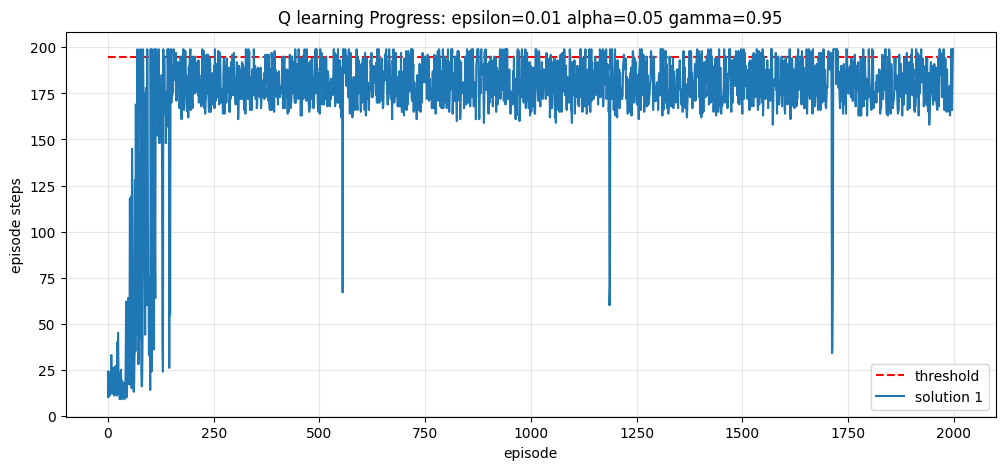


Training completed!
Average steps in last 100 episodes: 180.18
Max steps achieved: 199


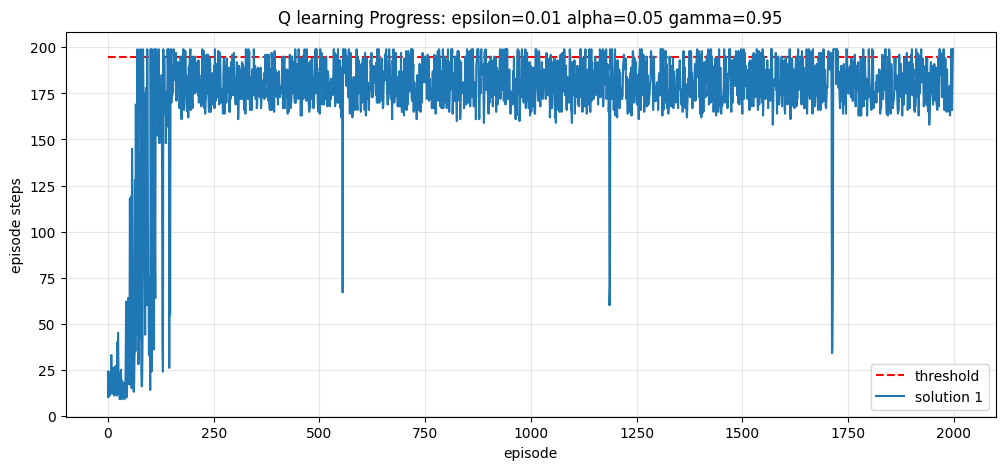

In [130]:
# Learning Parameters
epsilon = 1 # gready threashold
alpha = 0.09 # learning rate
gamma = 0.95 # reward discount factor
epsilon_decay = 0.995   # epsilon decay per episode
epsilon_min = 0.01 # minimum epsilon

# Execution parameters
SHOW_ANIMATION = False 
EPISODES_MAX = 2000
STEPS_MAX = 250
DESIRED_STEPS = 250

# Loggers
log_steps_number = np.zeros(EPISODES_MAX)

# Q-learning
for i_episode in range(EPISODES_MAX):

    result = env.reset()
    if isinstance(result, tuple):  # Gymnasium API
        observation = result[0]
    else:                          # Gym legacy API
        observation = result

    state = get_state(observation, n_buckets, state_bounds)

    # show results
    if (i_episode + 1) % 100 == 0:
        plt.figure(1, figsize=(12,5))
        plt.clf()
        plt.plot([0,i_episode], [195, 195], '--r', label="threshold")
        plt.plot(range(0,i_episode), log_steps_number[0:i_episode], label="solution 1")
        plt.xlabel('episode')
        plt.ylabel('episode steps')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.title(f'Q learning Progress: epsilon={epsilon} alpha={alpha} gamma={gamma}')
        display.clear_output(wait=True)
        display.display(plt.gcf())

    for t in range(STEPS_MAX):
        if SHOW_ANIMATION or (i_episode > 0.9*EPISODES_MAX and t > 0.95*DESIRED_STEPS):
            show_state(env.env, i_episode, t)

        action = choose_action(state, q_table, env.action_space, epsilon)
        observation, reward, terminated, truncated, info = env.step(action)

        next_state = get_state(observation, n_buckets, state_bounds)

        # Update Q table
        # TODO
        # # Q(s,a) = Q(s,a) + α * [r + γ * max(Q(s',a')) - Q(s,a)]
        best_next_action = np.argmax(q_table[next_state])
        td_target = reward + gamma * q_table[next_state][best_next_action]
        td_error = td_target - q_table[state][action]
        q_table[state][action] += alpha * td_error

        # Update current state
        state = next_state

        if terminated or truncated:
            log_steps_number[i_episode] = t
            break
    epsilon = modify_epsilon(i_episode)
    alpha = modify_alpha(i_episode)
    # Decay epsilon (exploration rate)
    # epsilon = max(epsilon_min, epsilon * epsilon_decay)


print("\nTraining completed!")
print(f"Average steps in last 100 episodes: {np.mean(log_steps_number[-100:]):.2f}")
print(f"Max steps achieved: {np.max(log_steps_number):.0f}")

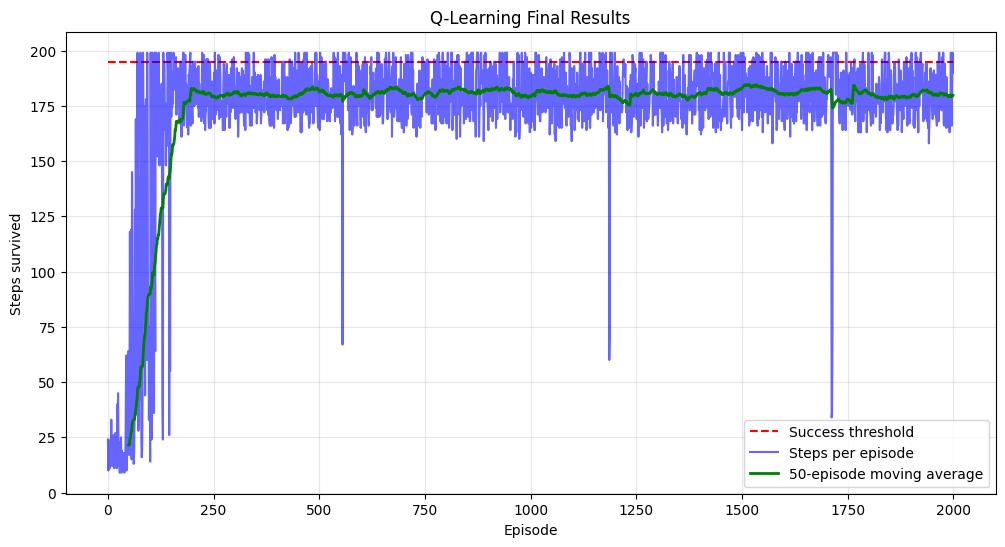

In [131]:
# Final plot
plt.figure(2, figsize=(12, 6))
plt.plot([0, EPISODES_MAX], [195, 195], 'r--', label="Success threshold")
plt.plot(range(EPISODES_MAX), log_steps_number, 'b-', alpha=0.6, label="Steps per episode")

# Moving average
window = 50
moving_avg = np.convolve(log_steps_number, np.ones(window)/window, mode='valid')
plt.plot(range(window-1, EPISODES_MAX), moving_avg, 'g-', linewidth=2, label=f"{window}-episode moving average")

plt.xlabel('Episode')
plt.ylabel('Steps survived')
plt.title('Q-Learning Final Results')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

env.close()